## Title :
Grad-CAM from scratch

## Description :
The goal of this exercise is to make a saliency map using Grad-CAM.

Your final image may resemble the one below:

<img src="../fig/fig.png" style="width: 500px;">

For this exercise, we will use the MobileNetV2 pre-trained model. You will apply Grad-CAM to the input cat image using what we learnt from lecture:

<img src="../fig/fig1.png" style="width: 500px;">

<img src="../fig/fig2.png" style="width: 500px;">

## Instructions:
- Load the pre-trained model and pre-process the given image to make a prediction.
- Find the predicted class of the image. It should be an **Egyptian cat**.
- Using the tf.keras Functional API, build a model that gives the model predictions and the feature maps after the last convolution in the pre-trained network.
- Using <a href="tf.GradientTape()" target="_blank">tf.GradientTape()</a> find the gradients of the output with respect to the activations.
- As per the Grad-CAM implementation, pool the gradients and find the heatmap.
- Upsample the heatmap using the helper function and superimpose it on the original image to get the output like the one shown above.

## Hints: 

<a href="https://keras.io/guides/sequential_model/" target="_blank">model.layers</a>Accesses layers of the model

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/activations/linear" target="_blank">tf.keras.activations.linear</a>Linear activation function

<a href="https://www.tensorflow.org/api_docs/python/tf/keras/Model" target="_blank">model.predict()</a>Used to predict the values given the model

<a href="https://keras.io/api/applications/mobilenet/#mobilenetv2-function" target="_blank">tf.keras.applications.mobilenet_v2.MobileNetV2</a>Instantiates the MobileNet v2 architecture.

In [3]:
# Import required libraries

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle

In [4]:
# Load the MobileNet V2 pre-trained model
# Rather than training a model from scratch we can use a pre trained
# model that has already been trained in the imagenet dataset
# MobileNetV2 is a SOTA model for image classification 
model = MobileNetV2(weights='imagenet')
model.summary()

2023-07-20 22:07:10.847526: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


14536120/14536120 [==============================] - 1s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
              

In [5]:
### edTest(test_chow1) ###

# Find the last convolutional layer
# Inspect the model summary and find the last convolution layer
# Get the name of the last convolution layer
conv_layer_name = model.layers[-3].name
print(conv_layer_name)

out_relu


In [7]:
# Take a sample image to find the saliency map
img_path = '../fig/cat.png'

# !!!!!!!!!!!
# how to process images

# Load the image with the target_size for mobilenet
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array 
x = image.img_to_array(img)

# Add an extra dimension for batch size 
# to change it to (1,224,224,3)
x = np.expand_dims(x, axis=0)

# Use the MobileNetV2 preprocess_input function on the image
x = preprocess_input(x)

In [10]:
# Use the pretrained model to make a prediction 
preds = model.predict(x)

# Useful dictionary to go from label index to actual label
with open('idx2name2.pkl', 'rb') as handle:
    keras_idx_to_name = pickle.load(handle)
    # A pickle file is a serialized data format in Python used to store Python objects in a binary representation.
    # "rb" binary read mode ('rb').

1/1 [==============================] - 0s 26ms/step


In [15]:
np.argmax(preds)

285

In [13]:
np.argmax(preds,axis=1)
# when using axis =1/0, it will return an array
# !!!!!!11

array([285])

In [11]:
# See what the output predictions is:
prediction_class = keras_idx_to_name[np.argmax(preds,axis=1).item(0)]
# ndarray.item(*args)
# int_type: this argument is interpreted as a flat index into the array, specifying which element to copy and return.
# Copy an element of an array to a standard Python scalar and return it.
print(f'Prediction class is {prediction_class}')

Prediction class is Egyptian cat



In [17]:
# We use the tf.keras Functional API to get 
# 1. The model prediction probabilities
# 2. The feature maps after the last convolution in the model

# Get the last convolution layer in the network
last_conv_layer = model.get_layer(conv_layer_name)
# !!!!!!!!!!

# Get the output predictions and the last_conv_layer
# Using tf.keras functional API
get_maps = Model(inputs = [model.inputs], outputs = [model.output, last_conv_layer.output])
# !!!!!!! two outputs

In [18]:
# Now we perform the Grad-CAM,
# We take the gradient of the output with respect to the feature maps
# after the convolution 
with tf.GradientTape() as tape:

    # Getting the required outputs 
    model_out, last_conv_layer = get_maps(x)
    
    # We choose the output with maximum probability
    # But this can be different depending on your choice
    # For eg. you could select the second highest probability value 
    class_out = tf.reduce_max(model_out)
    # find the maximum of elements across dimensions of a tensor.




⏸ **Take the gradients**

In [19]:
### edTest(test_chow2) ###

# We take the gradients 
# tape.gradient() takes the gradient of something with respect to 
# something else. Here we want the derivative of the output class
# with respect to to the last conv layer
grads = tape.gradient(class_out, last_conv_layer)

In [26]:
grads

<tf.Tensor: shape=(1, 7, 7, 1280), dtype=float32, numpy=
array([[[[-5.6594439e-05,  1.7308599e-04,  6.2806241e-05, ...,
           2.4664911e-04, -1.7276053e-04, -2.2973389e-04],
         [-5.6594439e-05,  1.7308599e-04,  6.2806241e-05, ...,
           2.4664911e-04, -1.7276053e-04, -2.2973389e-04],
         [-5.6594439e-05,  1.7308599e-04,  6.2806241e-05, ...,
           2.4664911e-04, -1.7276053e-04, -2.2973389e-04],
         ...,
         [-5.6594439e-05,  1.7308599e-04,  6.2806241e-05, ...,
           2.4664911e-04, -1.7276053e-04, -2.2973389e-04],
         [-5.6594439e-05,  1.7308599e-04,  6.2806241e-05, ...,
           2.4664911e-04, -1.7276053e-04, -2.2973389e-04],
         [-5.6594439e-05,  1.7308599e-04,  6.2806241e-05, ...,
           2.4664911e-04, -1.7276053e-04, -2.2973389e-04]],

        [[-5.6594439e-05,  1.7308599e-04,  6.2806241e-05, ...,
           2.4664911e-04, -1.7276053e-04, -2.2973389e-04],
         [-5.6594439e-05,  1.7308599e-04,  6.2806241e-05, ...,
          

In [20]:

# Here we combine all the gradients for each feature map 
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
# Computes the mean of elements across dimensions of a tensor.

  
# As per grad-CAM literature, here we need to multiply 
# the pooled grads with each feature map and take the average across
# all the feature maps to make the heat map
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
# tf.multiply: Returns an element-wise x * y.

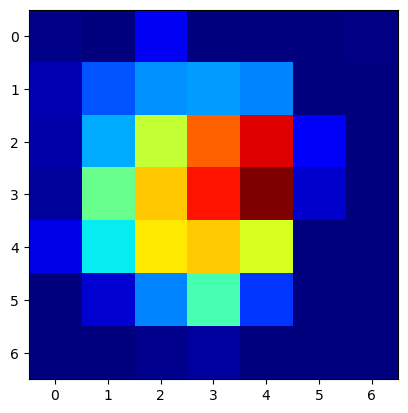

In [21]:
# Below we convert heatmap to numpy
# Make all values positive
# and reshape from (1,7,7) to (7,7) for ease of plotting
heatmap = heatmap.numpy()
heatmap[heatmap < 0] = 0 #relu
heatmap = (heatmap - heatmap.min())/(heatmap.max() - heatmap.min())
heatmap = heatmap.reshape((7, 7))

# We plot the (7,7) heatmap
plt.imshow(heatmap,cmap='jet')
plt.show()

In [22]:
# Inorder to map to the original image
# This heatmap has to be be resized
resized_heatmap = np.uint8(cv2.resize(heatmap,(224,224))*255)
# OpenCV (Open Source Computer Vision Library)
# cv2.resize(src, dsize[, dst[, fx[, fy[, interpolation]]]])
# resource, desired size of output, destination, 
# when resizing an image to a larger size, the quality and level of detail might not improve. 
# In this case, the algorithm interpolates the pixel values to fill the gaps between the original pixels, which might result in a slightly blurry image. 
# cv2.resize returns a floating-point array with values ranging from 0.0 to 1.0. The values represent the intensities of the pixels after the resizing operation, 
# with 0.0 being the minimum intensity (black) and 1.0 being the maximum intensity (white).
# np.uint8() function converts the floating-point array to an array of unsigned 8-bit integers (uint8). 
# This means that the pixel intensities will be represented as integers ranging from 0 to 255.

In [39]:
# We need to add a pre-processing step
# to convert the grayscale heatmap
# to a true JET colormap of 3 channels
# for ease of viewing
val = np.uint8(256-resized_heatmap)
# The heatmap values are expected to be in the range of 0 to 255.
# However, it is not guaranteed that the resized heatmap will be exactly in this range.
# The operation 256-resized_heatmap is used to adjust the range of the heatmap values to the 0-255 range before applying the color map.
heatmap_final = cv2.applyColorMap(val, cv2.COLORMAP_JET)
# OpenCV defines 12 colormaps that can be applied to a grayscale image using the function applyColorMap to produce a pseudocolored image.

In [40]:
# We also prepare the image for plotting
# by converting to tensor
# and converting dtype to int8
img = image.img_to_array(img)
img = np.uint8(img)

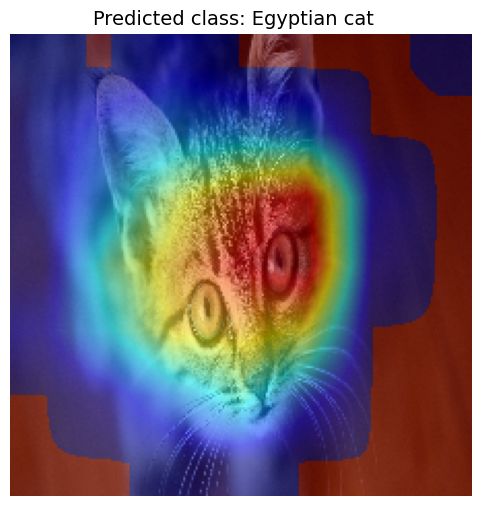

In [25]:
# Finally, we use the cv2.addweighted function
# to superimpose the heatmap on the original image
# Use the helper code below to do the same
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax.imshow(cv2.addWeighted(heatmap_final, 0.5, img, 0.5, 0))
# cv.addWeighted(src1, alpha, src2, beta, 0.0)
# beta = (1.0 - alpha)
ax.axis('off');
fig.suptitle(f'Predicted class: {prediction_class}',y=0.92,fontsize=14);
plt.show();

⏸ Will Grad-CAM work if we took the output from the last ReLU instead ? (True or False)

In [18]:
### edTest(test_chow3) ###

# Type your answer within in the quotes given 
answer3 = 'True'

⏸ The heatmap output is displaying:

A: The weights of the layer <br/>

B: A 7x7 mask from the input image <br/>

C: The pixels that activates the most in red and the least in blues <br/> 

D: A feature map of the input image <br/>

In [20]:
### edTest(test_chow4) ###

# Type your answer within in the quotes given 
answer4 = 'C'